In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import sklearn
from statsmodels.tsa.arima.model import ARIMA
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import BaggingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import LinearRegression
from sklearn import metrics
import warnings
import pickle
from sklearn.svm import SVR

warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('C:/Users/91738/Desktop/CogNight/input/sleepdata_2.csv')
df['Sleep Quality'] = df['Sleep Quality'].str.rstrip('%').astype('float') / 100.0
df = df[df['Sleep Quality']>0.4]
data = df['Sleep Quality'].copy().reset_index().drop('index',axis=1)
df[['Date','Time']] = df['Start'].str.split(expand=True)
data = df[['Date','Sleep Quality']].copy().reset_index().drop('index',axis=1)
data

,Date,Sleep Quality
0,12-05-2019,0.60
1,13-05-2019,0.73
2,14-05-2019,0.86
3,15-05-2019,0.77
4,16-05-2019,0.78
...,...,...
902,21-03-2022,0.82
903,23-03-2022,0.72
904,24-03-2022,0.71
905,28-03-2022,0.77


### LSTM

In [3]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
device

'cuda:0'

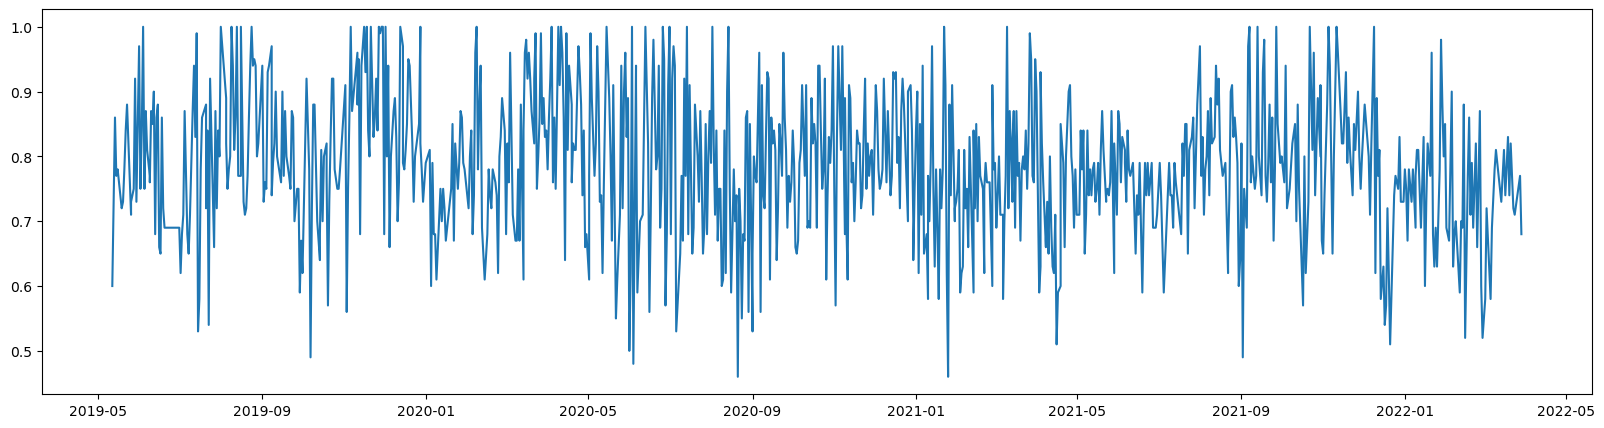

In [4]:
plt.figure(figsize=(20,5))
data['Date'] = pd.to_datetime(data['Date'],dayfirst=True)
plt.plot(data['Date'],data['Sleep Quality'])

In [5]:
from copy import deepcopy as dc

def prepare_dataframe_for_lstm(df, n_steps):
    df = dc(df)

    df.set_index('Date', inplace=True)

    for i in range(1, n_steps+1):
        df[f'Sleep Quality(t-{i})'] = df['Sleep Quality'].shift(i)

    df.dropna(inplace=True)

    return df

lookback = 7
shifted_df = prepare_dataframe_for_lstm(data, lookback)
shifted_df

,Sleep Quality,Sleep Quality(t-1),Sleep Quality(t-2),Sleep Quality(t-3),Sleep Quality(t-4),Sleep Quality(t-5),Sleep Quality(t-6),Sleep Quality(t-7)
Date,,,,,,,,
2019-05-21,0.78,0.73,0.72,0.78,0.77,0.86,0.73,0.60
2019-05-22,0.84,0.78,0.73,0.72,0.78,0.77,0.86,0.73
2019-05-23,0.88,0.84,0.78,0.73,0.72,0.78,0.77,0.86
2019-05-26,0.71,0.88,0.84,0.78,0.73,0.72,0.78,0.77
2019-05-26,0.73,0.71,0.88,0.84,0.78,0.73,0.72,0.78
...,...,...,...,...,...,...,...,...
2022-03-21,0.82,0.74,0.83,0.74,0.81,0.73,0.81,0.78
2022-03-23,0.72,0.82,0.74,0.83,0.74,0.81,0.73,0.81
2022-03-24,0.71,0.72,0.82,0.74,0.83,0.74,0.81,0.73


In [6]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(-1, 1))
shifted_df_as_np = shifted_df.to_numpy()
shifted_df_as_np = scaler.fit_transform(shifted_df_as_np)

X = shifted_df_as_np[:, 1:]
y = shifted_df_as_np[:, 0]

In [7]:
split_index = int(len(X) * 0.9)

X_train = X[:split_index]
X_test = X[split_index:]

y_train = y[:split_index]
y_test = y[split_index:]

X_train = X_train.reshape((-1, lookback, 1))
X_test = X_test.reshape((-1, lookback, 1))

y_train = y_train.reshape((-1, 1))
y_test = y_test.reshape((-1, 1))

In [8]:
X_train = torch.tensor(X_train).float()
y_train = torch.tensor(y_train).float()
X_test = torch.tensor(X_test).float()
y_test = torch.tensor(y_test).float()

X_train.shape, X_test.shape, y_train.shape, y_test.shape

(torch.Size([810, 7, 1]),
 torch.Size([90, 7, 1]),
 torch.Size([810, 1]),
 torch.Size([90, 1]))

In [9]:
from torch.utils.data import Dataset

class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, i):
        return self.X[i], self.y[i]

train_dataset = TimeSeriesDataset(X_train, y_train)
test_dataset = TimeSeriesDataset(X_test, y_test)

In [10]:
from torch.utils.data import DataLoader

batch_size = 15

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

for _, batch in enumerate(train_loader):
    x_batch, y_batch = batch[0].to(device), batch[1].to(device)
    print(x_batch.shape, y_batch.shape)
    break

torch.Size([15, 7, 1]) torch.Size([15, 1])


In [11]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_stacked_layers):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_stacked_layers = num_stacked_layers

        self.lstm = nn.LSTM(input_size, hidden_size, num_stacked_layers,
                            batch_first=True)

        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        batch_size = x.size(0)
        h0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)
        c0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)

        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

In [12]:
def train_one_epoch(model, train_loader, loss_function, optimizer):
    model.train(True)
    running_loss = 0.0

    for batch_index, batch in enumerate(train_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)

        output = model(x_batch)
        loss = loss_function(output, y_batch)
        running_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    avg_loss = running_loss / len(train_loader)

    return model, avg_loss


In [13]:
def validate_one_epoch(model, test_loader, loss_function):
    model.train(False)
    running_loss = 0.0

    for batch_index, batch in enumerate(test_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)

        with torch.no_grad():
            output = model(x_batch)
            loss = loss_function(output, y_batch)
            running_loss += loss.item()

    avg_loss = running_loss / len(test_loader)

    return avg_loss


In [14]:
learning_rate = 0.01
num_epochs = 100

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
model = LSTM(1, 4, 1).to(device)
loss_function = nn.L1Loss(reduction="mean")
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=0.001)

train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model, avg_train_loss = train_one_epoch(model, train_loader, loss_function, optimizer)
    avg_val_loss = validate_one_epoch(model, test_loader, loss_function)
    print(f"Epoch: {epoch}, Train Loss:{avg_train_loss}, Val Loss: {avg_val_loss}")
    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)


Epoch: 0, Train Loss:0.33353207453533457, Val Loss: 0.3267565096418063
Epoch: 1, Train Loss:0.3263556449501603, Val Loss: 0.33248719821373623
Epoch: 2, Train Loss:0.3256342805646084, Val Loss: 0.3063983768224716
Epoch: 3, Train Loss:0.324071969974924, Val Loss: 0.34116993347803753
Epoch: 4, Train Loss:0.3287080344226625, Val Loss: 0.32159655044476193
Epoch: 5, Train Loss:0.32677176263597274, Val Loss: 0.3098348379135132
Epoch: 6, Train Loss:0.32183363454209435, Val Loss: 0.3137699191768964
Epoch: 7, Train Loss:0.3217633460406904, Val Loss: 0.3206709424654643
Epoch: 8, Train Loss:0.3228183672935874, Val Loss: 0.3075086201230685
Epoch: 9, Train Loss:0.3220553238082815, Val Loss: 0.31664102524518967
Epoch: 10, Train Loss:0.3204240688571223, Val Loss: 0.3050257936120033
Epoch: 11, Train Loss:0.32351990044116974, Val Loss: 0.3082679286599159
Epoch: 12, Train Loss:0.3231727574710493, Val Loss: 0.32185320804516476
Epoch: 13, Train Loss:0.32181922373948274, Val Loss: 0.3166770363847415
Epoch: 

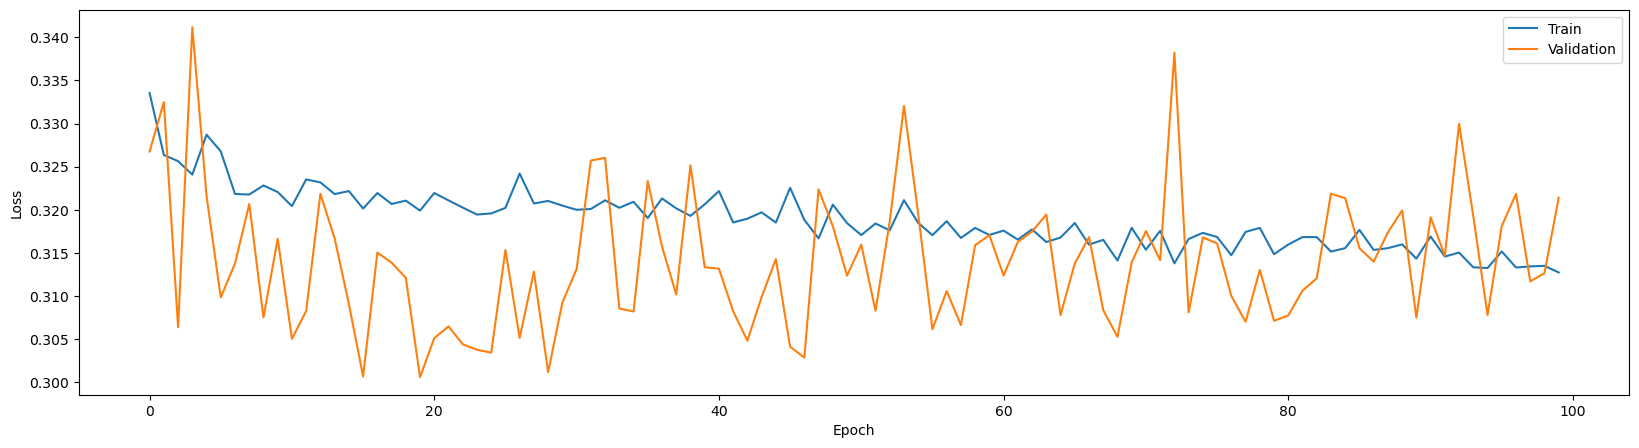

In [15]:
plt.figure(figsize=(20,5))
plt.plot(train_losses, label='Train')
plt.plot(val_losses, label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

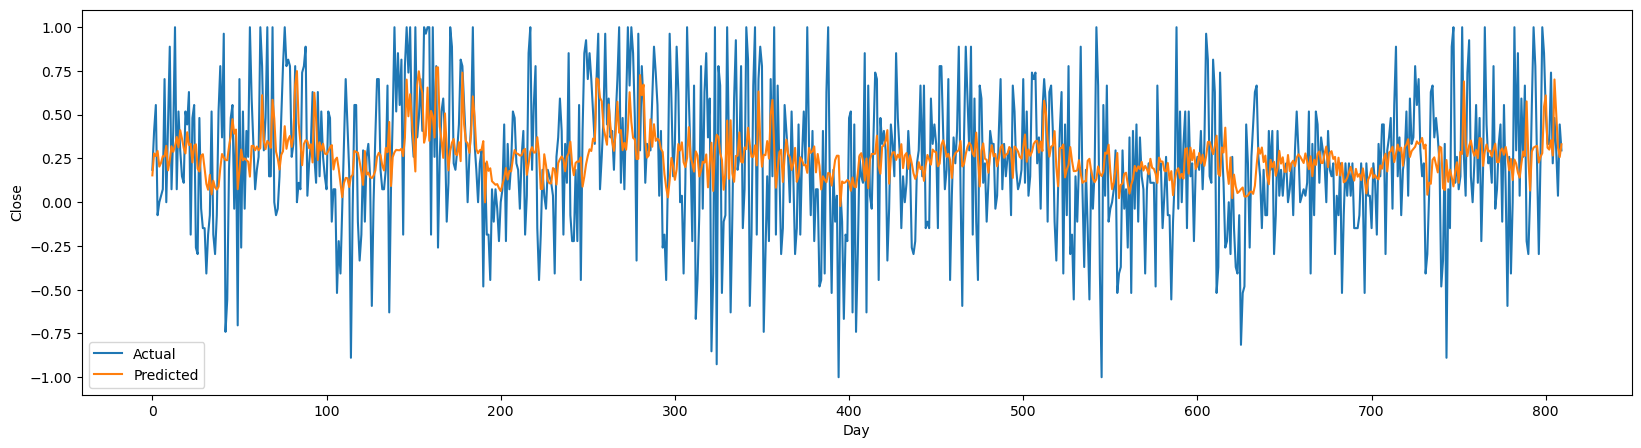

In [16]:
with torch.no_grad():
    predicted = model(X_train.to(device)).to('cpu').numpy()

predicted = predicted[0:]

plt.figure(figsize=(20,5))
plt.plot(y_train, label='Actual')
plt.plot(predicted, label='Predicted')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()

In [17]:
train_predictions = predicted.flatten()

dummies = np.zeros((X_train.shape[0], lookback+1))
dummies[:, 0] = train_predictions
dummies = scaler.inverse_transform(dummies)

train_predictions = dc(dummies[:, 0])
train_predictions[train_predictions >= 1] = 1


In [18]:
dummies = np.zeros((X_train.shape[0], lookback+1))
dummies[:, 0] = y_train.flatten()
dummies = scaler.inverse_transform(dummies)

new_y_train = dc(dummies[:, 0])

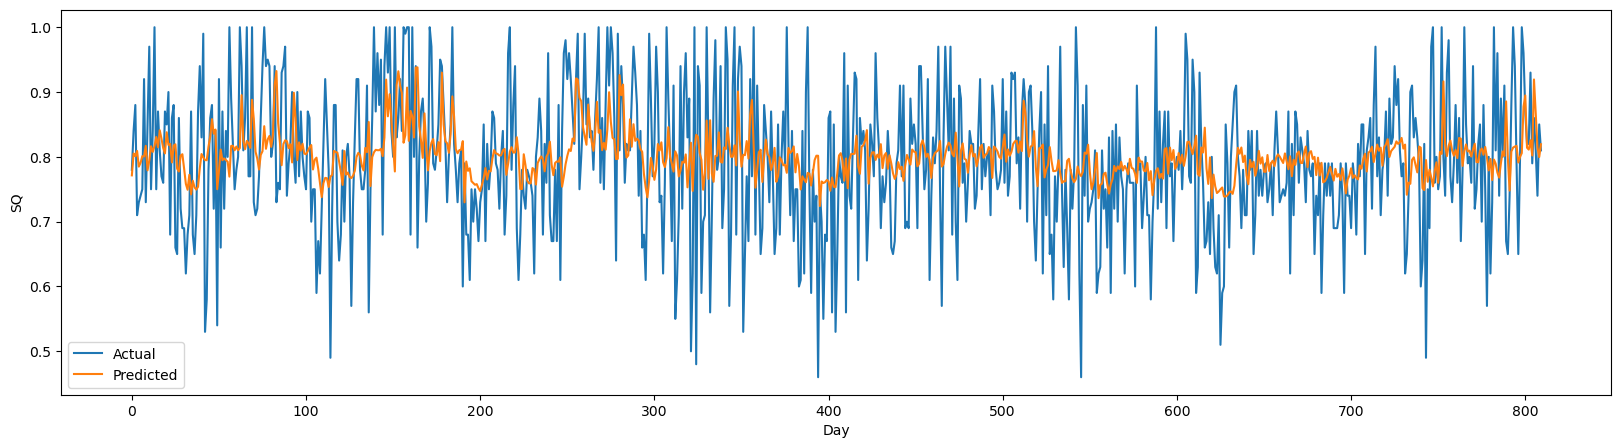

In [19]:
plt.figure(figsize=(20,5))
plt.plot(new_y_train, label='Actual')
plt.plot(train_predictions, label='Predicted')
plt.xlabel('Day')
plt.ylabel('SQ')
plt.legend()
plt.show()

In [20]:
test_predictions = model(X_test.to(device)).detach().cpu().numpy().flatten()

dummies = np.zeros((X_test.shape[0], lookback+1))
dummies[:, 0] = test_predictions
dummies = scaler.inverse_transform(dummies)

test_predictions = dc(dummies[:, 0])
test_predictions[test_predictions >= 1] = 1
test_predictions = test_predictions[1:]

In [21]:
dummies = np.zeros((X_test.shape[0], lookback+1))
dummies[:, 0] = y_test.flatten()
dummies = scaler.inverse_transform(dummies)

new_y_test = dc(dummies[:, 0])
new_y_test = new_y_test[:-1]

rmse = np.sqrt(np.mean((test_predictions-new_y_test)**2))

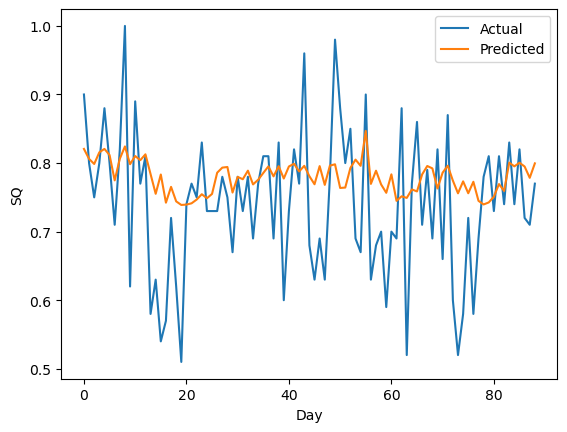


RMSE = 0.10229897210448166


In [22]:
plt.plot(new_y_test, label='Actual')
plt.plot(test_predictions, label='Predicted')
plt.xlabel('Day')
plt.ylabel('SQ')
plt.legend()
plt.show()
print("\nRMSE =",rmse)

In [25]:
tensor = torch.Tensor(scaler.fit_transform(df['Sleep Quality'][-lookback:].values.reshape(-1,1))).reshape(-1,7,1)
tensor = tensor.to(device)
pred = model(tensor).cpu().detach().numpy()
pred = scaler.inverse_transform(pred)
sq_lstm = pred.item()
pred.item()

0.7603264451026917

### ARIMA

In [26]:
y = df['Sleep Quality']*100
y = list(y)

In [29]:
arima = pickle.load(open('C:/Users/91738/Desktop/CogNight/models/arima_fit.pkl','rb'))
arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  612
Model:                 ARIMA(5, 4, 2)   Log Likelihood               -2396.706
Date:                Sat, 10 Feb 2024   AIC                           4809.413
Time:                        11:43:07   BIC                           4844.628
Sample:                             0   HQIC                          4823.118
                                - 612                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.3089      0.054    -24.432      0.000      -1.414      -1.204
ar.L2         -1.3940      0.082    -17.101      0.000      -1.554      -1.234
ar.L3         -1.0825      0.097    -11.216      0.000      -1.272      -0.893
ar.L4         -0.8364      0.090     -9.331      0.000      -1.012      -0.661
ar.L5         -0.2932      0.054     -5.436      0.000      -0.399      -0.187
ma.L1         -1.9917      1.247     -1.598      0.110      -4.435       0.452
ma.L2          0.9915      1.241      0.799      0.424      -1.440       3.423
sigma2       195.9062    242.597      0.808      0.419    -279.576     671.388
===================================================================================
Ljung-Box (L1) (Q):                  12.01   Jarque-Bera (JB):                 1.73
Prob(Q):                              0.00   Prob(JB):                         0.42
Heteroskedasticity (H):               1.23   Skew:                             0.04
Prob(H) (two-sided):                  0.14   Kurtosis:                         3.25
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [30]:
data1 = pd.read_csv('C:/Users/91738/Desktop/CogNight/input/data (2).csv')
y1 = list(data1.iloc[:,-1])
y1_final = np.concatenate((np.concatenate((np.concatenate((y1, y[:500])),y[:500])),y[:500]))

In [31]:
best_p,best_d,best_q = 5,4,2

arima = ARIMA(y1_final, order=(best_p, best_d, best_q), enforce_stationarity=False, enforce_invertibility=False)  # Replace p, d, q with appropriate values
arima_fit = arima.fit()

pred = arima_fit.forecast(1)
pred

array([77.03119553])

In [32]:
arima_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                31500
Model:                 ARIMA(5, 4, 2)   Log Likelihood             -106973.744
Date:                Sat, 10 Feb 2024   AIC                         213963.488
Time:                        11:44:13   BIC                         214030.348
Sample:                             0   HQIC                        213984.891
                              - 31500                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.5562      0.010   -154.552      0.000      -1.576      -1.537
ar.L2         -1.6515      0.016   -102.394      0.000      -1.683      -1.620
ar.L3         -1.3538      0.019    -72.302      0.000      -1.390      -1.317
ar.L4         -0.8768      0.016    -54.046      0.000      -0.909      -0.845
ar.L5         -0.3975      0.010    -39.617      0.000      -0.417      -0.378
ma.L1         -1.9985      0.017   -120.612      0.000      -2.031      -1.966
ma.L2          0.9986      0.017     59.773      0.000       0.966       1.031
sigma2        96.5048      1.617     59.675      0.000      93.335      99.674
===================================================================================
Ljung-Box (L1) (Q):                  99.36   Jarque-Bera (JB):             23052.31
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.95   Skew:                            -0.17
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.18
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Testing

In [33]:
# Use ARIMA for predicting on 310 points after 500 points

In [34]:
# test_data = 
arima = ARIMA(y[:601], order=(best_p, best_d, best_q), enforce_stationarity=False, enforce_invertibility=False)
arima_fit = arima.fit()

actual = y[601:]
pred = []

test_data = actual

In [35]:
for i in range(306):
    try:
        forecast = arima_fit.forecast(steps=1)
        prediction = forecast[0]
        print(i, "Actual =", actual[i], "Predicted =", prediction)
        pred.append(prediction)

        test_data = np.append(test_data, actual[i])
        arima = ARIMA(test_data, order=(best_p, best_d, best_q), enforce_stationarity=False, enforce_invertibility=False)
        arima_fit = arima.fit()
        
    except np.linalg.LinAlgError:
        
        model = ARIMA(test_data, order=(best_p, best_d, best_q), enforce_stationarity=False, enforce_invertibility=False)
        arima_fit = model.fit(method_kwargs={'enforce_stationarity': False, 'enforce_invertibility': False})


0 Actual = 69.0 Predicted = 85.00173726136117
1 Actual = 87.0 Predicted = 66.82182817246537
2 Actual = 77.0 Predicted = 81.27226067547807
3 Actual = 79.0 Predicted = 83.46748893972845
4 Actual = 67.0 Predicted = 79.93711276351978
5 Actual = 78.0 Predicted = 73.73854104945589
6 Actual = 80.0 Predicted = 77.25118886939872
7 Actual = 78.0 Predicted = 77.25713356783868
8 Actual = 84.0 Predicted = 74.99624776230738
9 Actual = 75.0 Predicted = 81.91000324797197
10 Actual = 82.0 Predicted = 78.62570100014534
11 Actual = 99.0 Predicted = 84.13425660989242
12 Actual = 95.0 Predicted = 93.24499958669588
13 Actual = 77.0 Predicted = 98.07652195788006
14 Actual = 76.0 Predicted = 83.04990569138181
15 Actual = 95.0 Predicted = 82.43469563493878
16 Actual = 90.0 Predicted = 92.66671752797875
17 Actual = 59.0 Predicted = 92.37867375281344
18 Actual = 63.0 Predicted = 63.21893758851691
19 Actual = 93.0 Predicted = 62.469753769493664
20 Actual = 82.0 Predicted = 84.58059968375392
21 Actual = 76.0 Predi

In [36]:
# more epochs - led to overfitting - gave a constant value for every single input 

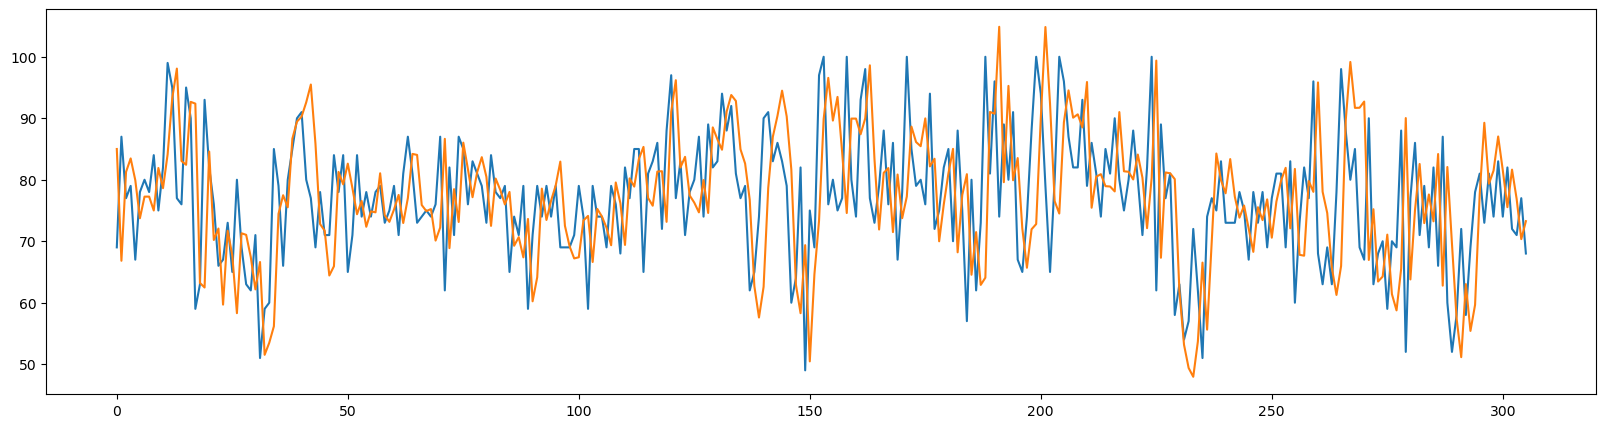

In [37]:
plt.figure(figsize=(20,5))
plt.plot(actual, label='Actual')
plt.plot(pred, label='Predicted')
plt.show()

In [38]:
import pickle
arima_fit.save('arima_fit.pkl')

### SLEEP SCORE PREDICTOR

In [39]:
arima_pred = pred
lstm_pred = predicted[:306]*100
df_ts = pd.DataFrame()
df_ts['arima'] = arima_pred
df_ts['lstm'] = lstm_pred*1.5
df_ts['actual'] = actual

X_ts = df_ts[['arima','lstm']]
Y_ts = df_ts['actual']

df_ts

,arima,lstm,actual
0,85.001737,23.021740,69.0
1,66.821828,41.795166,87.0
2,81.272261,39.553062,77.0
3,83.467489,43.976318,79.0
4,79.937113,30.508175,67.0
...,...,...,...
301,75.535077,28.095348,82.0
302,81.642813,49.875504,72.0
303,76.876307,44.281487,71.0
304,70.338008,51.310329,77.0


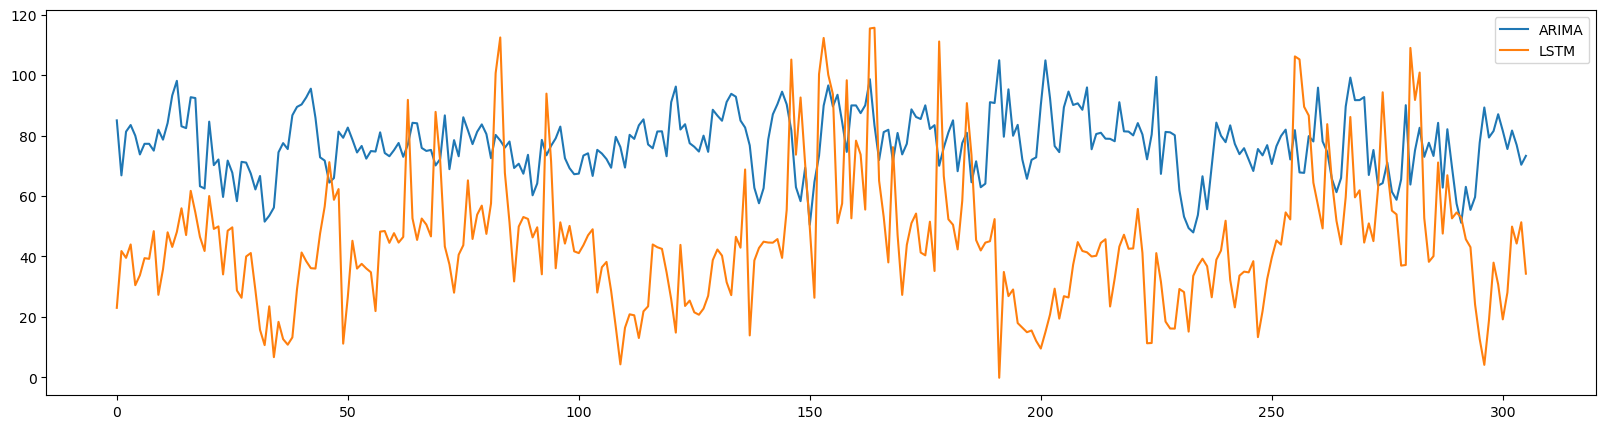

In [40]:
linear_model_ts = LinearRegression()
linear_model_ts.fit(X_ts,Y_ts)

Y_ts_pred = linear_model_ts.predict(X_ts)

plt.figure(figsize=(20,5))
plt.plot(arima_pred, label='ARIMA')
plt.plot(lstm_pred*1.5, label='LSTM')
plt.legend(['ARIMA','LSTM'])
plt.show()

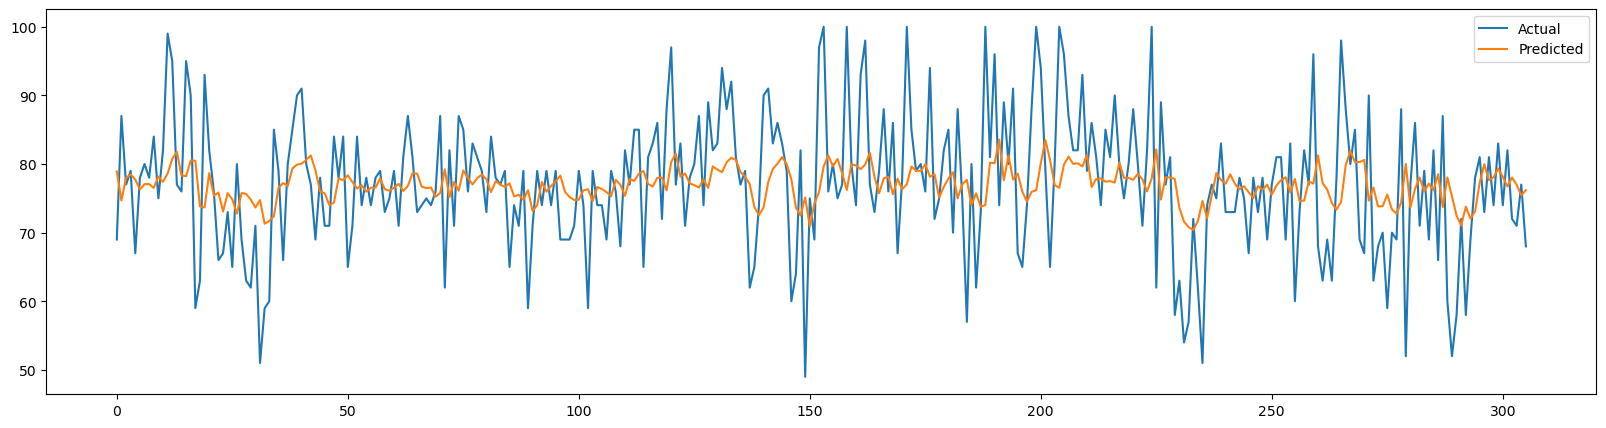

In [41]:
plt.figure(figsize=(20,5))
plt.plot(Y_ts, label='Actual')
plt.plot(Y_ts_pred, label='Predicted')
plt.legend(['Actual','Predicted'])
plt.show()

### MLP

In [42]:
dfml = pd.read_csv('C:/Users/91738/Desktop/CogNight/input/Sleep_Efficiency.csv')
dfml = dfml.drop(['Bedtime', 'Wakeup time', 'ID','REM sleep percentage','Deep sleep percentage','Light sleep percentage','Awakenings'] ,axis=1)
dfml['Smoking status'] = dfml['Smoking status'].map({'Yes':1 ,'No':0})
dfml['Gender'] = dfml['Gender'].map({'Male':1 ,'Female':0})
cols = [i for i in dfml.columns if i not in ["Sleep efficiency","Sleep duration"]]
dfml = dfml.dropna()
for col in cols:
  dfml[col] = dfml[col].astype(int)
dfml = dfml.reset_index().drop('index',axis=1)
dfml['Caffeine consumption'] = (dfml['Caffeine consumption']/25).astype(int)
dfml

,Age,Gender,Sleep duration,Sleep efficiency,Caffeine consumption,Alcohol consumption,Smoking status,Exercise frequency
0,65,0,6.0,0.88,0,0,1,3
1,69,1,7.0,0.66,0,3,1,3
2,40,0,8.0,0.89,0,0,0,3
3,40,0,6.0,0.51,2,5,1,1
4,57,1,8.0,0.76,0,3,0,3
...,...,...,...,...,...,...,...,...
402,30,0,7.5,0.53,2,2,1,1
403,27,0,7.5,0.91,0,0,0,5
404,52,1,6.0,0.74,1,0,0,3
405,45,1,7.0,0.76,0,0,0,3


In [43]:
# # Sleep duration - hrs
# Gender - 0-f; 1-m/
# caffeine - 0,-10
# alcohol - 0-5
# smoking - yes -1 , no - 2
# # exercise freuq - 5/10

In [44]:
X = dfml.copy()
Y = dfml['Sleep duration']
X = X.drop('Sleep duration',axis=1)

x_train = dfml[ :int(len(dfml)*0.9)].drop('Sleep duration',axis=1)
x_test = dfml[int(len(dfml)*0.9): ].reset_index().drop(['index','Sleep duration'],axis=1)
y_train = dfml['Sleep duration'][ :int(len(dfml)*0.9)].reset_index().drop(['index'],axis=1)
y_test = dfml['Sleep duration'][int(len(dfml)*0.9): ].reset_index().drop(['index'],axis=1)

x_train.shape, x_test.shape, y_train.shape, y_test.shape

((366, 7), (41, 7), (366, 1), (41, 1))

In [45]:
X

,Age,Gender,Sleep efficiency,Caffeine consumption,Alcohol consumption,Smoking status,Exercise frequency
0,65,0,0.88,0,0,1,3
1,69,1,0.66,0,3,1,3
2,40,0,0.89,0,0,0,3
3,40,0,0.51,2,5,1,1
4,57,1,0.76,0,3,0,3
...,...,...,...,...,...,...,...
402,30,0,0.53,2,2,1,1
403,27,0,0.91,0,0,0,5
404,52,1,0.74,1,0,0,3
405,45,1,0.76,0,0,0,3


In [46]:
mlpr = MLPRegressor(hidden_layer_sizes=(1,),solver='adam',learning_rate_init=0.1,random_state=25)
mlpr.fit(X, Y)

y_pred_whole = mlpr.predict(x_test)
ame = sklearn.metrics.mean_absolute_error(y_test, y_pred_whole)
mse = sklearn.metrics.mean_squared_error(y_test, y_pred_whole)
print("Mean absolute error = ",ame)
print("Mean square error = ",mse)

Mean absolute error =  0.5532355002665309
Mean square error =  0.5075179670119147


### SVM

In [47]:
X

,Age,Gender,Sleep efficiency,Caffeine consumption,Alcohol consumption,Smoking status,Exercise frequency
0,65,0,0.88,0,0,1,3
1,69,1,0.66,0,3,1,3
2,40,0,0.89,0,0,0,3
3,40,0,0.51,2,5,1,1
4,57,1,0.76,0,3,0,3
...,...,...,...,...,...,...,...
402,30,0,0.53,2,2,1,1
403,27,0,0.91,0,0,0,5
404,52,1,0.74,1,0,0,3
405,45,1,0.76,0,0,0,3


In [48]:
svm = SVR(kernel='rbf')
svm.fit(X,Y)

y_pred = svm.predict(x_test)
err = mean_squared_error(y_test, y_pred)
print(err)

0.5313471233180178


### COMBINED SLEEP DURATION PREDICTOR

In [49]:
linear_model = LinearRegression()
d = []

for i in range(len(X)):
    row = X.iloc[i,:]
    mlp_sleep = mlpr.predict([row])[0]
    svm_sleep = svm.predict([row])[0]

    d.append([mlp_sleep,svm_sleep])

d = pd.DataFrame(d)
linear_model.fit(d,Y)

LinearRegression()

### COMBINED PREDICTOR

In [58]:
prev_sleep_scores = []
for i in range(7):
    prev_sleep_scores.append(int(input("Enter your sleep scores for last seven days (out of 100).")))

age = int(input("Please enter your age :"))
age = (69 - age)/60

gender = int(input("Please specify your gender  (0:Female, 1:Male):"))
caffeine = int(input("Your caffiene intake for the day (between 0 and 9)")) 
alcohol = int(input("Alcohol(on a scale of 0 to 5):"))
smoking = int(input("Smoking status(0 for No, 1 for Yes):")) 
exercise = int(input("Exercise(on a scale of 0 to 5:)"))

inp = np.array(prev_sleep_scores)
tensor = torch.Tensor(scaler.fit_transform(inp.reshape(-1,1))).reshape(1,7,1).to(device)
op = model(tensor).cpu().detach().numpy()
op = scaler.inverse_transform(op)

lstm_score = op[0][0]
print("LSTM prediction =",lstm_score)

test_data = np.append(test_data, prev_sleep_scores)
arima = ARIMA(test_data, order=(best_p, best_d, best_q), enforce_stationarity=False, enforce_invertibility=False)
arima_fit = arima.fit()
arima_pred = arima_fit.forecast(1)[0]
print("ARIMA prediction =",arima_pred)

final_sleep_score = linear_model_ts.predict([[arima_pred, lstm_score]])
print("Predicted sleep score = ", final_sleep_score)

feature_in = [age, gender, arima_pred/100, caffeine, alcohol, smoking, exercise]

mlp_time = mlpr.predict([feature_in])
print("MLP time prediction =", mlp_time)

svm_time = svm.predict([feature_in])
print("SVM time prediction =", svm_time)

sleep_duration_pred = linear_model.predict([[mlp_time[0], svm_time[0]]])

print("Required sleep duration = ", round(sleep_duration_pred[0],2),"hrs")

LSTM prediction = 76.48831
ARIMA prediction = 75.20992618817408
Predicted sleep score =  [76.45168033]
MLP time prediction = [6.86120919]
SVM time prediction = [7.93081052]
Required sleep duration =  7.98 hrs
